In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# for handling and parsing email files
import email
import os
import re
import nltk

In [3]:
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from collections import Counter

In [4]:
# modeling
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score, confusion_matrix

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [5]:
# load ham and spam files
ham_fnames = [name for name in sorted(os.listdir("main_ham"))]
spam_fnames = [name for name in sorted(os.listdir("main_spam"))]

In [6]:
hl, sl = len(ham_fnames), len(spam_fnames)

print("Number of ham files:", hl)
print("Number of spam files:", sl)
print("Spam to Ham ratio:", sl/hl)
print("Spam percentage: ", (sl / (sl + hl)) * 100, "%")

Number of ham files: 6951
Number of spam files: 2397
Spam to Ham ratio: 0.3448424687095382
Spam percentage:  25.641848523748394 %


In [7]:
def parse_email(fname, spam=False):
    directory = "main_spam" if spam else "main_ham"
    with open(os.path.join(directory, fname), "rb") as fp:
        return email.parser.BytesParser().parse(fp)
        
ham_emails = [parse_email(name) for name in ham_fnames]
spam_emails = [parse_email(name, spam=True) for name in spam_fnames]

In [8]:
# total
len(ham_emails + spam_emails)

9348

In [9]:
test_email = ham_emails[0]
print(test_email)

Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34
	for <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 21 Aug 2002 13:33:03 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7LCXvZ24654 for
    <jm-exmh@jmason.org>; Wed, 21 Aug 2002 13:33:57 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id F12A13EA25; Wed, 21 Aug 2002
    08:34:00 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp.spamassassin.taint.org (int-mx1.corp.spamassassin.taint.org
    [172.16.52.254

In [10]:
hamPlusSpamData = ham_emails + spam_emails
labels = ["ham"]*len(ham_emails) + ["spam"]*len(spam_emails)
raw_df = pd.DataFrame({"label": labels, "email": hamPlusSpamData})

In [11]:
raw_df.sample(5)

,label,email
7309,spam,"[Return-Path, Delivery-Date, Received, Receive..."
7596,spam,"[Return-Path, Delivery-Date, Received, Receive..."
8330,spam,"[Received, Message-Id, Date, X-Sender, X-MailI..."
5933,ham,"[Return-Path, Delivered-To, Received, Received..."
8551,spam,"[Return-Path, Delivered-To, Received, Received..."


In [12]:
# missing values
raw_df.isnull().sum()

label    0
email    0
dtype: int64

In [13]:
# check for duplicate values
raw_df.duplicated().sum()

0

In [14]:
raw_df.shape

(9348, 2)

<AxesSubplot: >

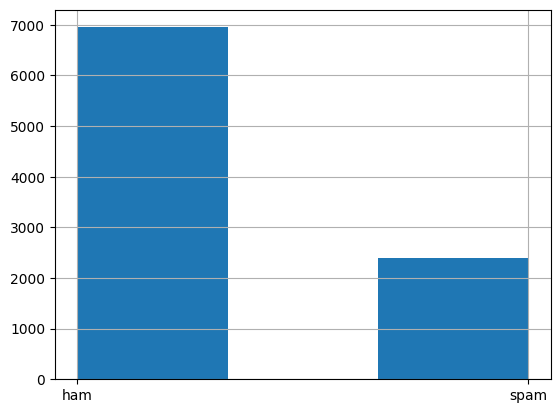

In [15]:
# get an overview of the data

raw_df.label.hist(bins=3)

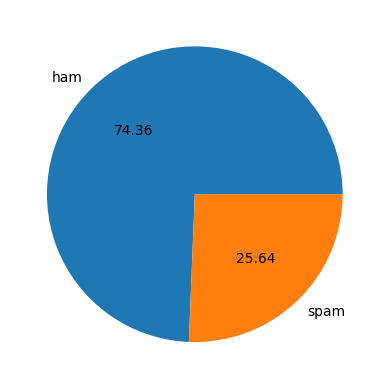

In [16]:
import matplotlib.pyplot as plt
plt.pie(raw_df['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PCC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PCC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
print("Header fields: ", test_email.keys())
print("Field values: ", test_email.values())
print("Email content: ", test_email.get_payload())

Header fields:  ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'Cc', 'Subject', 'In-Reply-To', 'References', 'MIME-Version', 'Content-Type', 'Message-Id', 'X-Loop', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'Date']
Field values:  ['<exmh-workers-admin@spamassassin.taint.org>', 'yyyy@localhost.netnoteinc.com', 'from localhost (localhost [127.0.0.1])\n\tby phobos.labs.netnoteinc.com (Postfix) with ESMTP id 7106643C34\n\tfor <jm@localhost>; Wed, 21 Aug 2002 08:33:03 -0400 (EDT)', 'from phobos [127.0.0.1]\n\tby localhost with IMAP (fetchmail-5.9.0)\n\tfor jm@localhost (single-drop); Wed, 21 Aug 2002 13:33:03 +0100 (IST)', 'from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by\n    dogma.slashnull.org (8

In [26]:
test_email.get_content_type()

'text/plain'

In [27]:
multi_email = None

for mail in ham_emails:
    if mail.is_multipart():
        multi_email = mail
        break

# Payload will be list of email.message.Message
print(multi_email.get_payload())

# Nested get payload
print(multi_email.get_payload()[0].get_payload())
print(multi_email.items())

[<email.message.Message object at 0x00000211D9ACA610>, <email.message.Message object at 0x00000211D9ACA0A0>]
> From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 20

In [28]:
# function to get the structure of email (multipart or single)

def get_structure(email) -> str:
    # can be a non leaf
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join(
            get_structure(message)
            for message in payload
        ))
    else:
        return email.get_content_type()

In [29]:
get_structure(test_email)

'text/plain'

In [30]:
get_structure(multi_email)

'multipart(text/plain, application/pgp-signature)'

In [31]:
# Function to count all the structures
def email_structure_counter(emails):
    structs = Counter()
    for mail in emails:
        mail_struct = get_structure(mail)
        structs[mail_struct] += 1
    return structs

ham_structs = email_structure_counter(ham_emails)
spam_structs = email_structure_counter(spam_emails)

In [32]:
def draw_wordcloud(structs): 
    wordcloud = WordCloud(width=1600, height=800, random_state=3301)
    wordcloud.generate_from_frequencies(frequencies=structs)

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

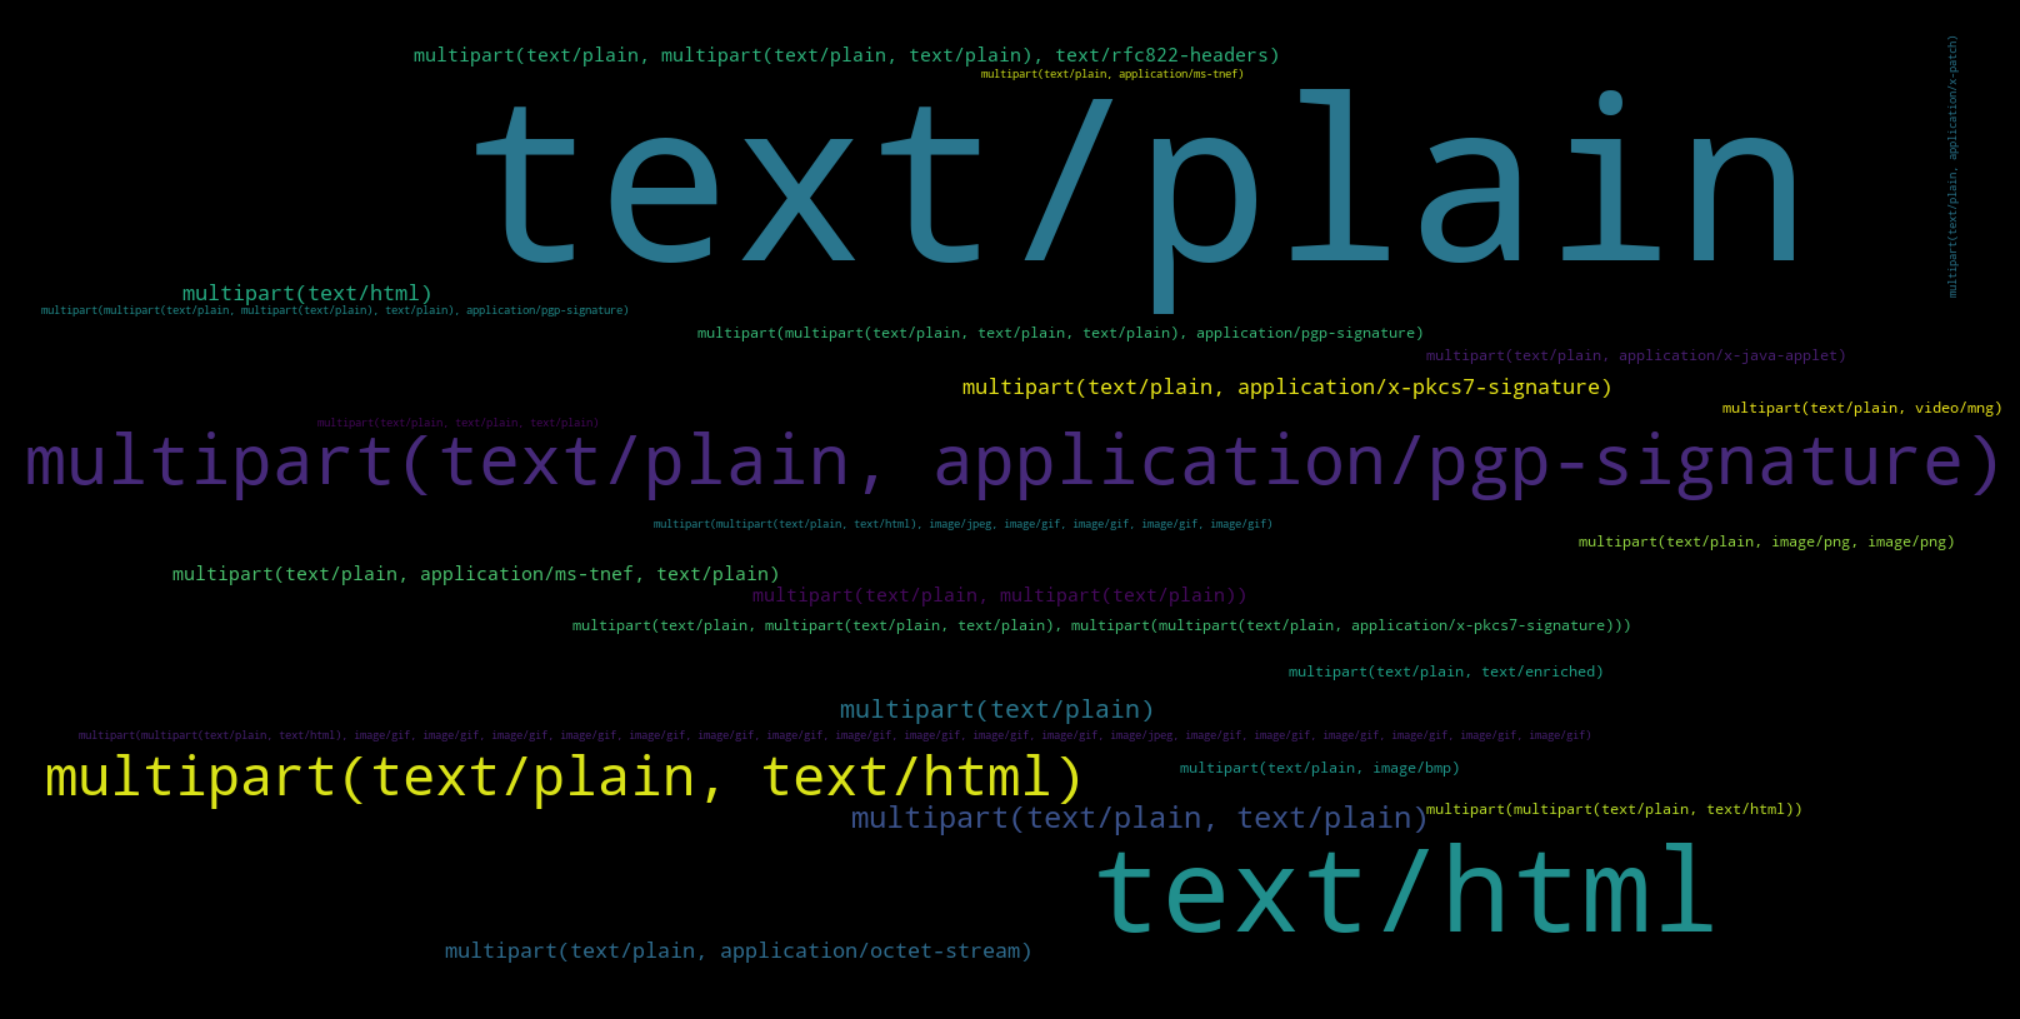

[('text/plain', 6371),
 ('text/html', 240),
 ('multipart(text/plain, application/pgp-signature)', 173),
 ('multipart(text/plain, text/html)', 109),
 ('multipart(text/plain, text/plain)', 9),
 ('multipart(text/plain)', 6),
 ('multipart(text/plain, application/x-pkcs7-signature)', 4),
 ('multipart(text/html)', 4),
 ('multipart(text/plain, application/octet-stream)', 4),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 3),
 ('multipart(text/plain, multipart(text/plain))', 3),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  3),
 ('multipart(text/plain, image/bmp)', 2),
 ('multipart(text/plain, text/enriched)', 2),
 ('multipart(multipart(text/plain, text/html))', 2),
 ('multipart(text/plain, image/png, image/png)', 2),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  2),
 ('multipart(text/plain, video/mng)', 2),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain,

In [33]:
draw_wordcloud(ham_structs)
ham_structs.most_common()

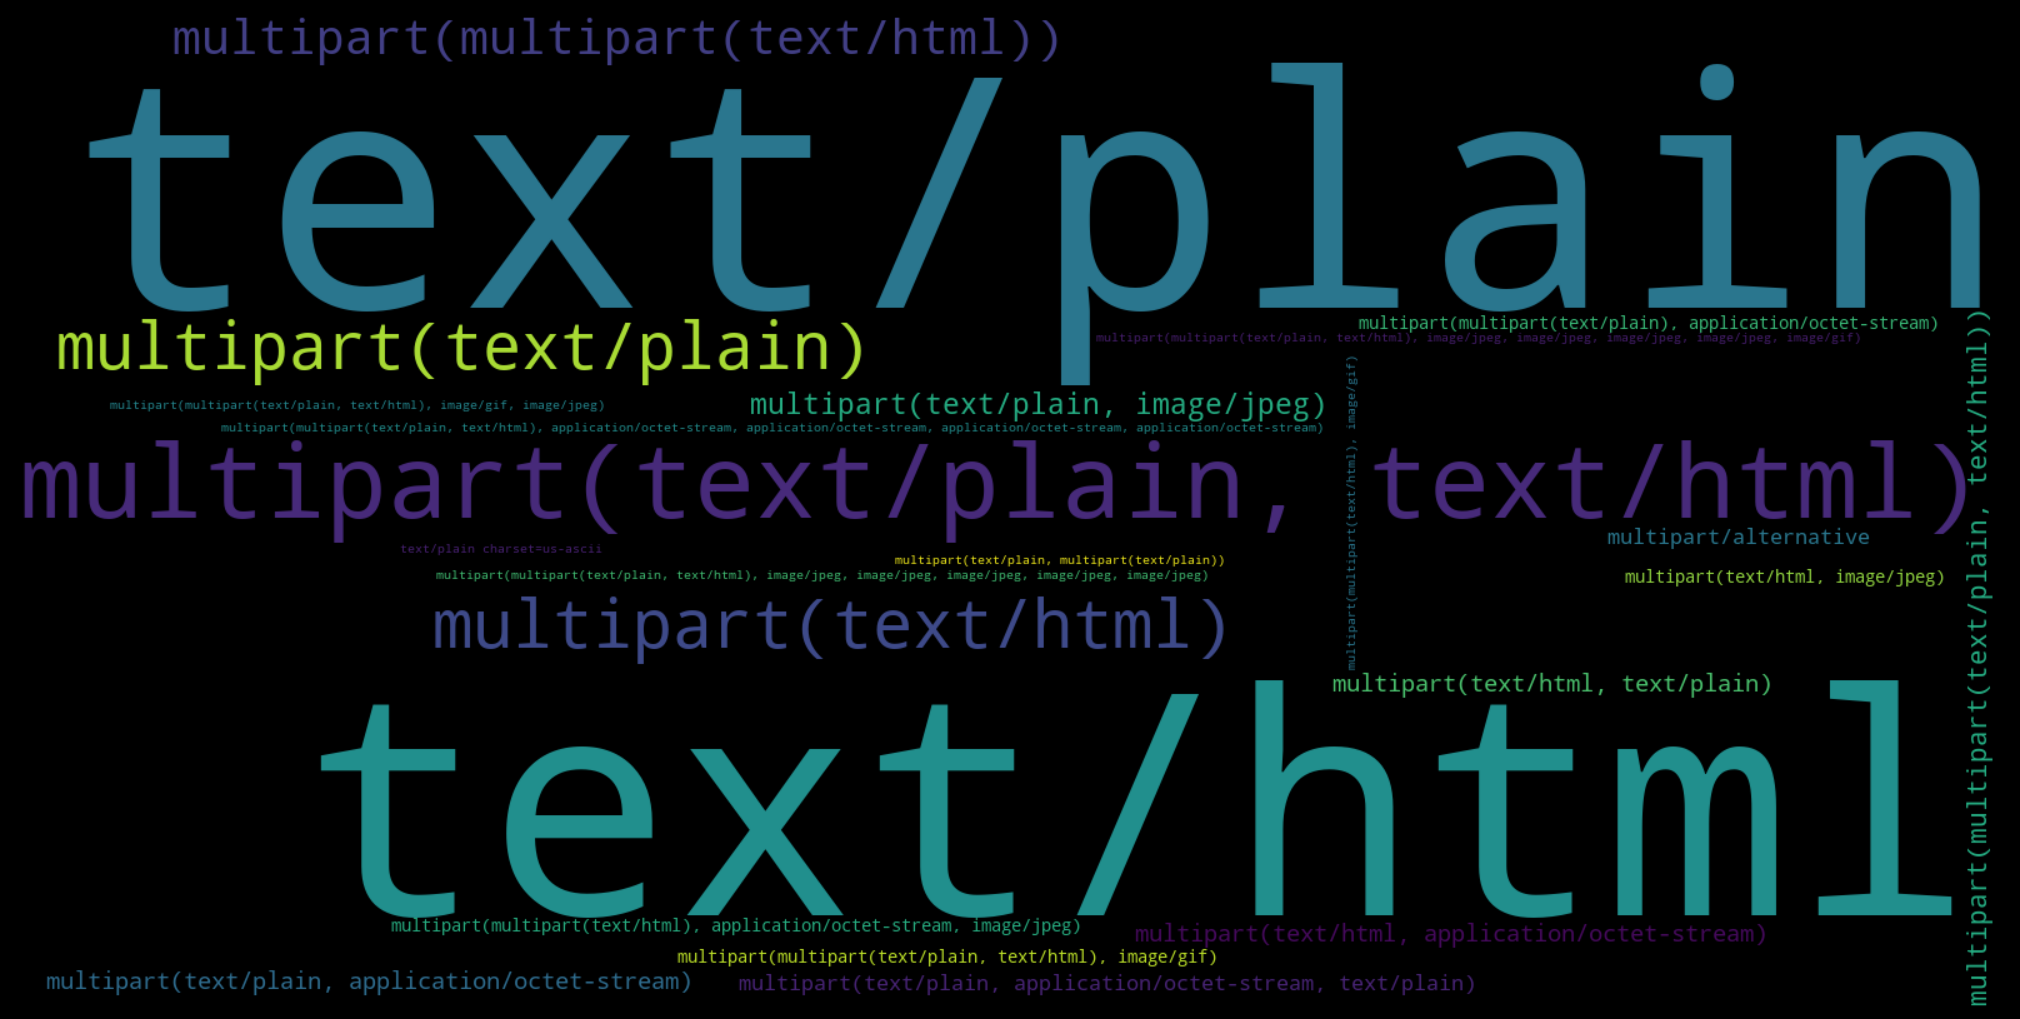

[('text/plain', 1037),
 ('text/html', 953),
 ('multipart(text/plain, text/html)', 204),
 ('multipart(text/html)', 68),
 ('multipart(text/plain)', 63),
 ('multipart(multipart(text/html))', 28),
 ('multipart(text/plain, image/jpeg)', 6),
 ('multipart(multipart(text/plain, text/html))', 5),
 ('multipart(text/plain, application/octet-stream)', 4),
 ('multipart(text/html, text/plain)', 4),
 ('multipart(text/html, application/octet-stream)', 4),
 ('multipart(text/plain, application/octet-stream, text/plain)', 3),
 ('multipart/alternative', 3),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 2),
 ('multipart(multipart(text/plain, text/html), image/gif)', 2),
 ('multipart(text/html, image/jpeg)', 2),
 ('multipart(multipart(text/plain), application/octet-stream)', 2),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(multipart(text/plain, text/html), image/jpeg, image/jpeg, image/jpeg, image/jpeg, image/jpeg)',
  1),
 ('multipart(multipart(text/plain,

In [21]:
draw_wordcloud(spam_structs)
spam_structs.most_common()

In [34]:
html_email = None

for email in spam_emails:
    if get_structure(email) == 'text/html':
        html_email = email
        break

print(html_email.get_payload())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=
ype>
<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=
ules=3Dnone 
style=3D"COLOR: black; DISPLAY: none" width=3D"100%">
  <TBODY>
  <TR>
    <TD colSpan=3D3>
      <HR color=3Dblack noShade SIZE=3D1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3D3>
      <HR color=3Dblack noShade SIZE=3D1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=
 --><FONT 
color=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=
/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 
face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=
0000 
face=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">
<CENTER>Why

In [35]:
def html_to_text(email) -> str:
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "nothing"

In [36]:
print(html_to_text(html_email))

</TR> Save up to 70% on Life Insurance. Why Spend More Than You Have To? Life Quote Savings Ensuring your family's financial security is very important. Life Quote Savings makes buying life insurance simple and affordable. We Provide FREE Access to The Very Best Companies and The Lowest Rates. Life Quote Savings is FAST, EASY and SAVES you money! Let us help you get started with the best values in the country on new coverage. You can SAVE hundreds or even thousands of dollars by requesting a FREE quote from Lifequote Savings. Our service will take you less than 5 minutes to complete. Shop and compare. SAVE up to 70% on all types of Life insurance! Click Here For Your Free Quote! Protecting your family is the best investment you'll ever make! If you are in receipt of this email in error and/or wish to be removed from our list, PLEASE CLICK HERE AND TYPE REMOVE. If you reside in any state which prohibits e-mail solicitations for insurance, please disregard this email.


In [38]:
# General purpose function to convert an email to plain text
def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content

print("Ham email in plain text:\n", email_to_text(ham_emails[3]))
print("Spam email in plain text:\n", email_to_text(spam_emails[3]))

Ham email in plain text:
 > From:  Valdis.Kletnieks@vt.edu
> Date:  Wed, 21 Aug 2002 02:36:56 -0400
>
> --==_Exmh_778588528P
> Content-Type: text/plain; charset=us-ascii
> 
> On Tue, 20 Aug 2002 22:51:52 EDT, Valdis.Kletnieks@vt.edu said:
> 
> > Ever tried to get MH to *not* have a 'pseq' sequence?  I suspect everybod
> y's
> > looking at a big box that has unseen and pseq in it.  Might want to add
> > 'pseq' to the 'hide by default' list....
> 
> Was it intended that if you added a sequence to the 'never show' list that
> it not take effect till you stopped and restarted exmh?  I added 'pseq',
> then hit 'save' for Preferences - didn't take effect till I restarted.

No it wasn't, and at one point it worked fine.  I'll check and see why it 
stopped working.

Chris
-- 
Chris Garrigues                 http://www.DeepEddy.Com/~cwg/
virCIO                          http://www.virCIO.Com
716 Congress, Suite 200
Austin, TX  78701		+1 512 374 0500

  World War III:  The Wrong-Doers Vs. the Evi

In [40]:
content_ham_emails = [email_to_text(email) for email in ham_emails]
content_spam_emails = [email_to_text(email) for email in spam_emails]

In [41]:
content_hamPlusSpamData = content_ham_emails + content_spam_emails
labels = ["ham"]*len(content_ham_emails) + ["spam"]*len(content_spam_emails)
df = pd.DataFrame({"label": labels, "email": content_hamPlusSpamData})

In [42]:
df.sample(5)

,label,email
4005,ham,URL: http://jeremy.zawodny.com/blog/archives/0...
3550,ham,To continue the subject on an otherwise unrela...
4903,ham,"Adam Beberg writes:\n> On Tue, 3 Sep 2002, Kra..."
9166,spam,That's Not Rush Hour Traffic...\n It's The 'F...
4066,ham,URL: http://boingboing.net/#85497383\nDate: No...


In [43]:
df['num_characters'] = df['email'].apply(len)
df.head()

,label,email,num_characters
0,ham,"Date: Tue, 20 Aug 2002 17:27:47 -05...",6753
1,ham,"Date: Wed, 21 Aug 2002 10:54:46 -05...",1604
2,ham,\n======================== THE MOTLEY FOOL ===...,7050
3,ham,> From: Valdis.Kletnieks@vt.edu\n> Date: Wed...,986
4,ham,"Martin A posted:\nTassos Papadopoulos, the Gre...",899


In [44]:
# num of words
df['num_words'] = df['email'].apply(lambda x:len(nltk.word_tokenize(x)))
df.head()

,label,email,num_characters,num_words
0,ham,"Date: Tue, 20 Aug 2002 17:27:47 -05...",6753,1427
1,ham,"Date: Wed, 21 Aug 2002 10:54:46 -05...",1604,284
2,ham,\n======================== THE MOTLEY FOOL ===...,7050,1336
3,ham,> From: Valdis.Kletnieks@vt.edu\n> Date: Wed...,986,204
4,ham,"Martin A posted:\nTassos Papadopoulos, the Gre...",899,206


In [45]:
df['num_sentences'] = df['email'].apply(lambda x:len(nltk.sent_tokenize(x)))
df.head()

,label,email,num_characters,num_words,num_sentences
0,ham,"Date: Tue, 20 Aug 2002 17:27:47 -05...",6753,1427,23
1,ham,"Date: Wed, 21 Aug 2002 10:54:46 -05...",1604,284,7
2,ham,\n======================== THE MOTLEY FOOL ===...,7050,1336,80
3,ham,> From: Valdis.Kletnieks@vt.edu\n> Date: Wed...,986,204,7
4,ham,"Martin A posted:\nTassos Papadopoulos, the Gre...",899,206,6


In [46]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,9348.000000,9348.000000,9348.000000
mean,2084.135430,387.977963,15.250428
std,5403.706236,879.452682,29.763083
min,0.000000,0.000000,0.000000
25%,565.750000,103.000000,5.000000
50%,1037.000000,197.000000,8.000000
75%,1900.000000,368.000000,15.000000
max,194824.000000,18579.000000,809.000000


In [47]:
# ham
df[df['label'] == 'ham'][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,6951.000000,6951.000000,6951.000000
mean,1895.517336,364.565386,14.132643
std,5133.911235,830.896372,28.677155
min,47.000000,3.000000,1.000000
25%,522.500000,98.000000,4.000000
50%,976.000000,193.000000,8.000000
75%,1711.000000,347.000000,14.000000
max,194824.000000,18579.000000,809.000000


In [48]:
#spam
df[df['label'] == 'spam'][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,2397.000000,2397.000000,2397.000000
mean,2631.104297,455.871506,18.491865
std,6087.389045,1004.217851,32.498562
min,0.000000,0.000000,0.000000
25%,700.000000,116.000000,5.000000
50%,1204.000000,207.000000,10.000000
75%,2533.000000,446.000000,18.000000
max,126335.000000,18447.000000,408.000000


<AxesSubplot: xlabel='num_characters', ylabel='Count'>

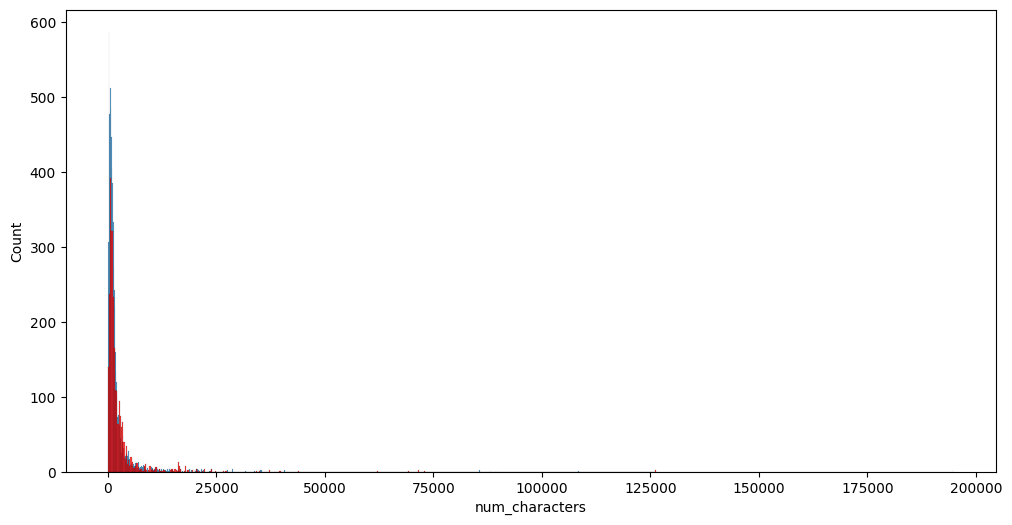

In [49]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 'ham']['num_characters'])
sns.histplot(df[df['label'] == 'spam']['num_characters'],color='red')

<AxesSubplot: xlabel='num_words', ylabel='Count'>

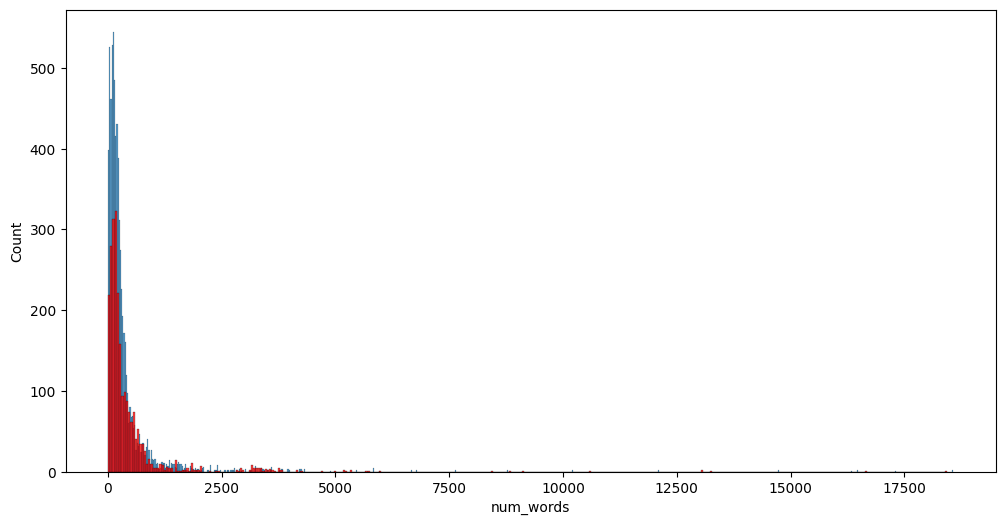

In [50]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['label'] == 'ham']['num_words'])
sns.histplot(df[df['label'] == 'spam']['num_words'],color='red')

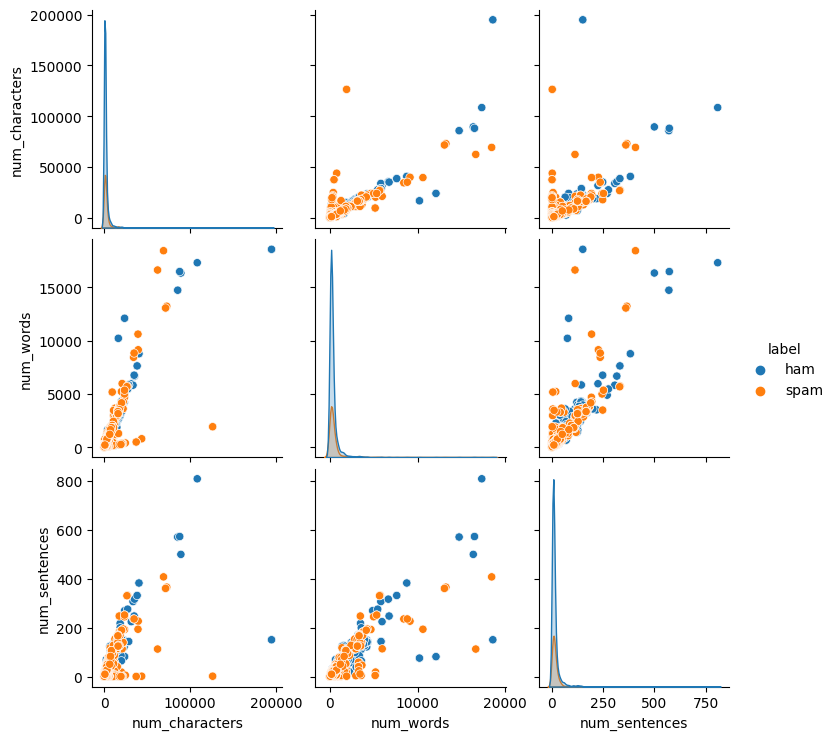

In [53]:
sns.pairplot(df,hue='label')

C:\Users\PCC\AppData\Local\Temp\ipykernel_14412\4277794465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<AxesSubplot: >

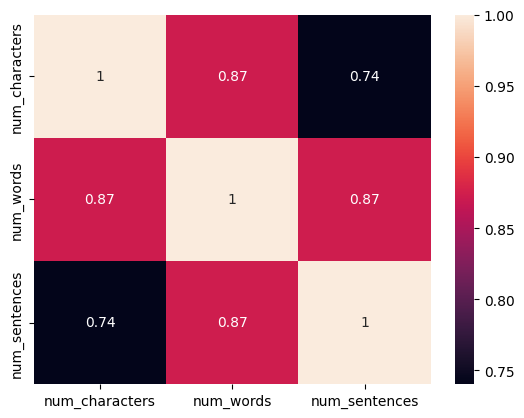

In [54]:
sns.heatmap(df.corr(),annot=True)

In [39]:
text = "Hello, today I am going to London for performing and dancing"
stemmer = nltk.PorterStemmer()

for word in text.split():
    stemmed_word = stemmer.stem(word)
    print(stemmed_word, end=" ")

hello, today i am go to london for perform and danc 

In [55]:
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

In [27]:
class EmailToWordsCount(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, to_lowercase=True, remove_stopw=True, remove_punc=True, do_stem=True):
        self.strip_headers = strip_headers
        self.to_lowercase = to_lowercase
        self.remove_stopw = remove_stopw
        self.remove_punc = remove_punc
        self.do_stem = do_stem
        
        # To perform stemming
        self.stemmer = nltk.PorterStemmer()
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_word_counts = []
        for email in X:
            # text of the email
            plain = email_to_text(email)
            if plain is None:
                plain = "nothing"
            
            if self.to_lowercase:
                plain = plain.lower()
            
            if self.remove_punc:
                plain = plain.replace(".", "")
                plain = plain.replace(",", "")
                plain = plain.replace("!", "")
                plain = plain.replace("?", "")
                plain = plain.replace(";", "")
                
            word_counts = Counter(plain.split())
            if self.do_stem:
                # Stem the word, and add their counts
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    root_word = self.stemmer.stem(word)
                    stemmed_word_counts[root_word] += count
                word_counts = stemmed_word_counts
            
            X_word_counts.append(word_counts)
        return np.array(X_word_counts)

In [28]:
X_few = spam_emails[1:3]
ewc = EmailToWordsCount()
X_few_counts = ewc.fit_transform(X_few)
print(X_few_counts)

[Counter({'save': 8, 'you': 7, 'to': 6, 'life': 6, 'quot': 5, 'and': 5, 'the': 5, 'insur': 4, 'in': 4, 'on': 3, 'your': 3, 'is': 3, 'free': 3, 'best': 3, 'of': 3, 'up': 2, '70%': 2, 'than': 2, 'veri': 2, 'make': 2, 'from': 2, 'our': 2, 'type': 2, 'click': 2, 'here': 2, 'for': 2, 'if': 2, 'thi': 2, 'email': 2, 'remov': 2, 'pleas': 2, '</tr>': 1, 'whi': 1, 'spend': 1, 'more': 1, 'have': 1, 'ensur': 1, "family'": 1, 'financi': 1, 'secur': 1, 'import': 1, 'buy': 1, 'simpl': 1, 'afford': 1, 'we': 1, 'provid': 1, 'access': 1, 'compani': 1, 'lowest': 1, 'rate': 1, 'fast': 1, 'easi': 1, 'money': 1, 'let': 1, 'us': 1, 'help': 1, 'get': 1, 'start': 1, 'with': 1, 'valu': 1, 'countri': 1, 'new': 1, 'coverag': 1, 'can': 1, 'hundr': 1, 'or': 1, 'even': 1, 'thousand': 1, 'dollar': 1, 'by': 1, 'request': 1, 'a': 1, 'lifequot': 1, 'servic': 1, 'will': 1, 'take': 1, 'less': 1, '5': 1, 'minut': 1, 'complet': 1, 'shop': 1, 'compar': 1, 'all': 1, 'protect': 1, 'famili': 1, 'invest': 1, "you'll": 1, 'ever':

In [29]:
class WordCountVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    # train on list of word counts and build vocabulary
    def fit(self, X, y=None):
        total_word_counts = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_word_counts[word] += count
                
        # Build a vocabulary out of total most common
        self.most_common = total_word_counts.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: i for i, (word, count) in enumerate(self.most_common)}
    
        return self
    # Create the vector out of vocabulary
    def transform(self, X, y=None):
        X_new = np.zeros([X.shape[0], self.vocabulary_size + 1], dtype=int)
        
        # The vectors will contain additional column for counts of words
        # not captured in vocabulary
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                col = self.vocabulary_.get(word, self.vocabulary_size)
                X_new[row, col] += count
                
        return X_new

In [31]:
vectorizer = WordCountVectorizer(vocabulary_size=10)
X_few_vector = vectorizer.fit_transform(X_few_counts)

print("Vector of word counts:\n", X_few_vector)
print("Vocabulary generated:\n", vectorizer.vocabulary_)

Vector of word counts:
 [[  7   5   6   5   3   4   2   8   1   3 128]
 [ 12  13  10   7   8   7   8   1   8   5 498]]
Vocabulary generated:
 {'you': 0, 'the': 1, 'to': 2, 'and': 3, 'on': 4, 'in': 5, 'our': 6, 'save': 7, 'protect': 8, 'is': 9}


In [32]:
email_to_cvector = Pipeline([
    ("emailToWords", EmailToWordsCount()), 
    ("wordCountVectorizer", WordCountVectorizer())
])

In [33]:
X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

C:\Users\PCC\AppData\Local\Temp\ipykernel_15940\1604658743.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(ham_emails + spam_emails)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=3301)

print("Training set size: ", X_train.shape, y_train.shape)
print("Testing set size: ", X_test.shape, y_test.shape)

Training set size:  (7478,) (7478,)
Testing set size:  (1870,) (1870,)


In [35]:
# prepare the training and testing set 
X_train_prepared = email_to_cvector.fit_transform(X_train)
X_train_prepared

array([[  0,   1,   1, ...,   0,   0,  14],
       [  7,   7,   7, ...,   0,   0,  73],
       [  1,   5,   3, ...,   0,   0,  60],
       ...,
       [ 14,   9,   7, ...,   0,   0, 135],
       [  2,   5,   8, ...,   0,   0,  43],
       [  0,   3,   0, ...,   0,   0,  17]])

In [36]:
X_test_prepared = email_to_cvector.transform(X_test)
X_test_prepared

array([[  0,   0,   0, ...,   0,   0,   5],
       [  2,   5,   2, ...,   0,   0,  17],
       [ 52,  44,  20, ...,   0,   0, 178],
       ...,
       [  0,   0,   0, ...,   0,   0,  19],
       [  5,   3,   1, ...,   0,   0,  26],
       [  0,   4,   2, ...,   0,   0,  22]])

In [37]:
def comp_esti(esti, Xtr=X_train_prepared, Xte=X_test_prepared, ytr=y_train, yte=y_test):
    esti.fit(Xtr, ytr)
    esti_test_preds = esti.predict(Xte)
    
    print(f"{esti} Accuracy score: ", accuracy_score(yte, esti_test_preds))
    print(f"\n{esti} Classification report:\n", classification_report(yte, esti_test_preds, digits=6))
    
    # confusion matrix
    cf_mat = confusion_matrix(yte, esti_test_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(data=cf_mat, annot=True, ax=ax)
    plt.show()

SVC(kernel='linear', random_state=3301) Accuracy score:  0.9855614973262032

SVC(kernel='linear', random_state=3301) Classification report:
               precision    recall  f1-score   support

           0   0.992035  0.988456  0.990242      1386
           1   0.967280  0.977273  0.972251       484

    accuracy                       0.985561      1870
   macro avg   0.979657  0.982864  0.981246      1870
weighted avg   0.985628  0.985561  0.985586      1870



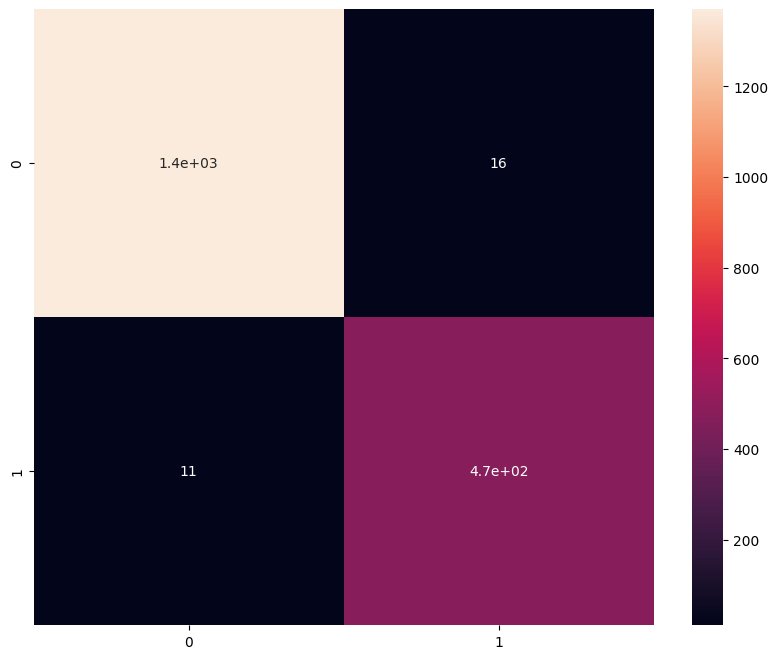

MultinomialNB() Accuracy score:  0.9497326203208556

MultinomialNB() Classification report:
               precision    recall  f1-score   support

           0   0.960770  0.971861  0.966284      1386
           1   0.916667  0.886364  0.901261       484

    accuracy                       0.949733      1870
   macro avg   0.938718  0.929113  0.933772      1870
weighted avg   0.949355  0.949733  0.949454      1870



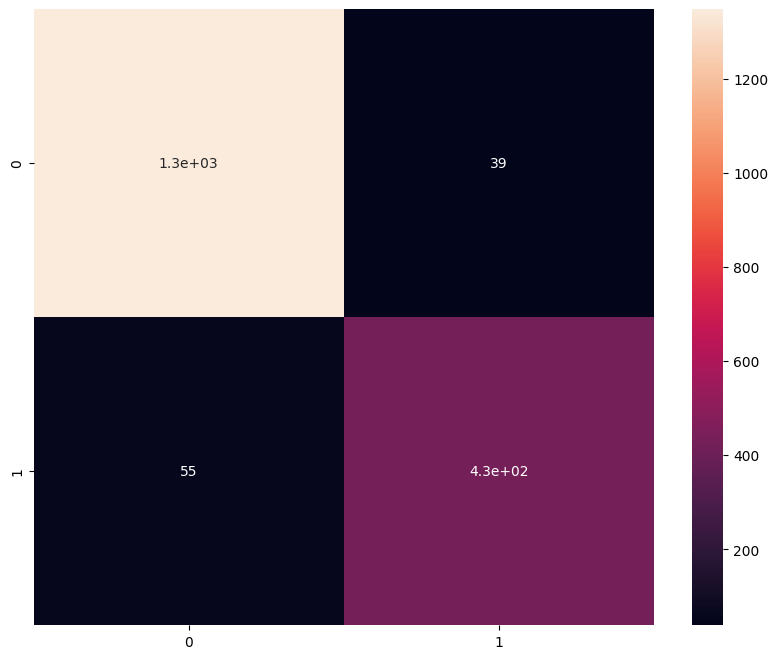

In [39]:
estimators = [
    SVC(kernel='linear', random_state=3301),
    MultinomialNB(),
]

# run
for esti in estimators:
    comp_esti(esti)